In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# We begin reading the data into a pandas dataframe.
cookies = pd.read_csv('../bayes_mcmc/cookies.txt', sep=' ')
cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In [5]:
cookies['location'].unique()

array([1, 2, 3, 4, 5])

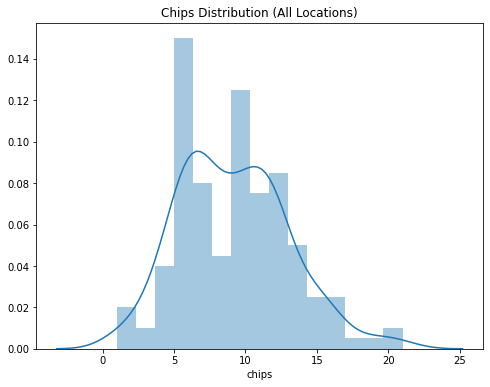

In [6]:
# Histogram distribution of chocolate chips
# for all cookies.
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(cookies['chips'], bins=15, ax=ax);
ax.set(title='Chips Distribution (All Locations)');

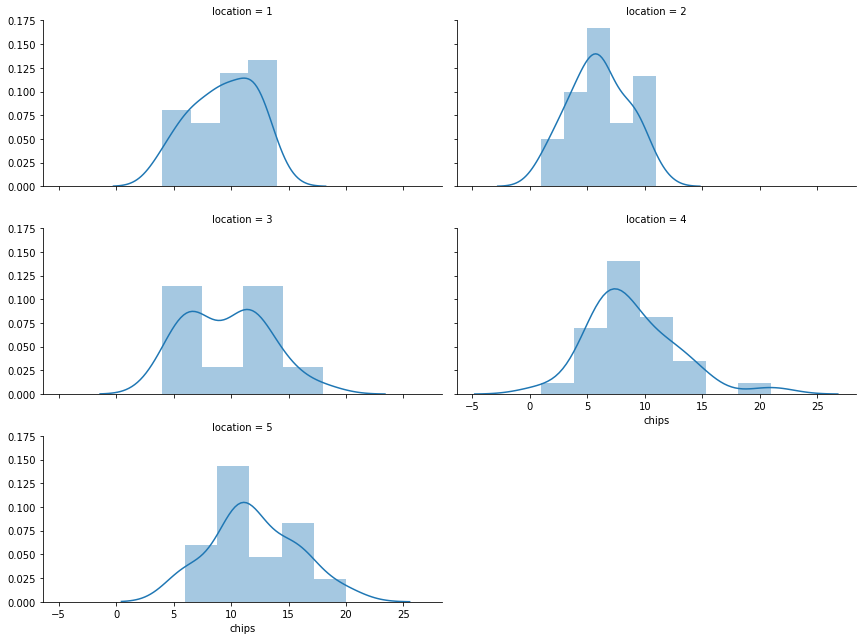

In [7]:
# Histogram distribution of chocolate chips
# for cookies in each location.
g = sns.FacetGrid(data=cookies, col='location', col_wrap=2, height=3, aspect=2)
g = g.map(sns.distplot, 'chips')

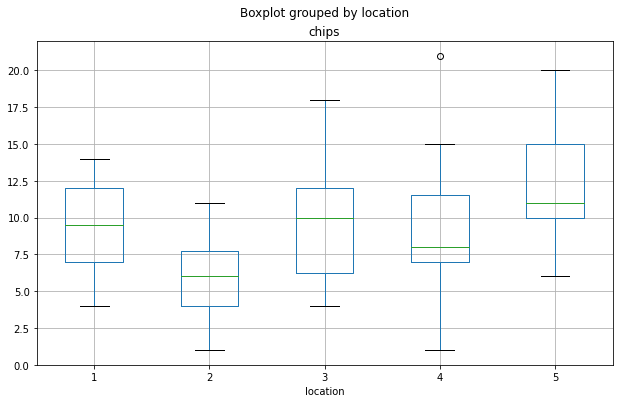

In [8]:
# Box plot for different locations.
fig, ax = plt.subplots(figsize=(10,6))
cookies.boxplot(column='chips', by='location', ax=ax);

In [12]:
import scipy.stats as ss

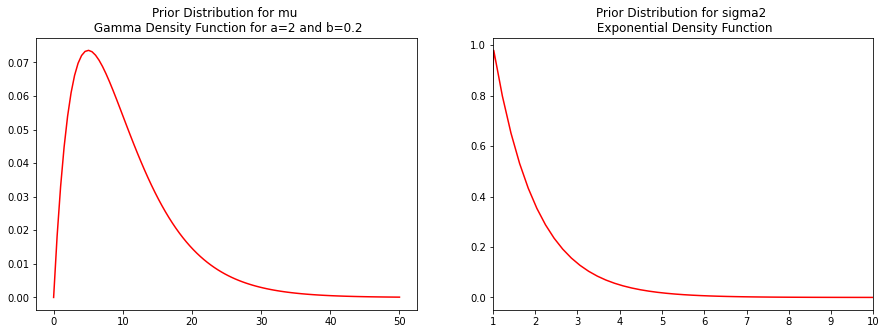

In [13]:
x = np.linspace(start=0, stop=50, num=100)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x, ss.gamma.pdf(x,a=2,scale=5), 'r-')
plt.title('Prior Distribution for mu \n Gamma Density Function for a={} and b={}'.format(2, 1/5))

plt.subplot(1, 2, 2)
x = np.linspace(0,10)
plt.plot(x, ss.expon.pdf(x,1), 'r-')
plt.title('Prior Distribution for sigma2 \n Exponential Density Function')
plt.xlim(1,10);

In [14]:
model = pm.Model()

with model:
    
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    
    # Parametrization for the shape parameter.
    alpha =  mu**2/sigma**2
    
    # Parametrization for the scale parameter.
    beta = mu/sigma**2
    
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        shape=cookies.location.values.max()
    )
    
    # Likelihood function for the data.
    chips = [
        pm.Poisson('chips_{}'.format(i),lam[i], 
        observed=cookies[cookies.location==i+1].chips.values) 
        for i in range(cookies.location.values.max())
    ] 
    
    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 1000, 3
    
    n_sim = n_draws*n_chains
    
    trace = pm.sample(draws=n_draws, chains=n_chains)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [lam, sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:06<00:00, 737.66draws/s] 


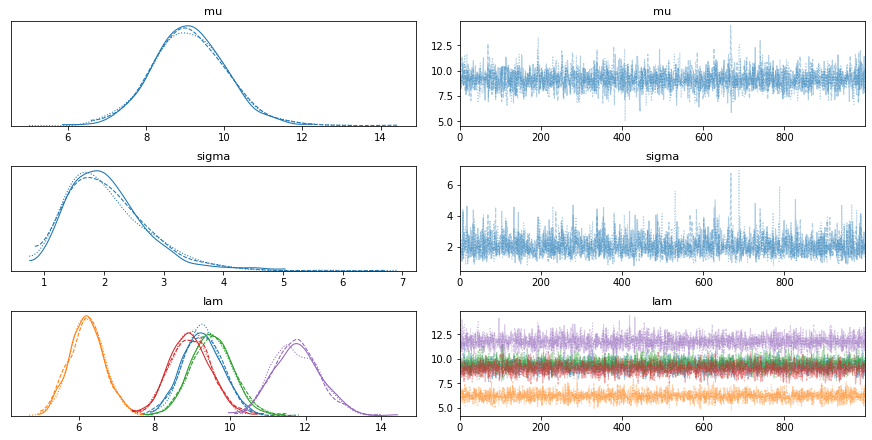

In [15]:
pm.traceplot(trace);

In [16]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,9.123,0.949,7.307,10.871,0.018,0.013,2656.0,2543.0,2768.0,2054.0,1.0
sigma,2.065,0.683,0.956,3.259,0.014,0.010,2423.0,2162.0,2703.0,2004.0,1.0
lam[0],9.275,0.523,8.326,10.275,0.008,0.006,4033.0,4028.0,4024.0,2330.0,1.0
lam[1],6.221,0.462,5.320,7.058,0.008,0.005,3711.0,3711.0,3684.0,1931.0,1.0
lam[2],9.528,0.555,8.501,10.572,0.008,0.006,4452.0,4431.0,4434.0,2301.0,1.0
lam[3],8.951,0.545,7.986,10.008,0.009,0.006,3901.0,3897.0,3884.0,2349.0,1.0
lam[4],11.766,0.624,10.596,12.919,0.010,0.007,3543.0,3539.0,3524.0,2274.0,1.0


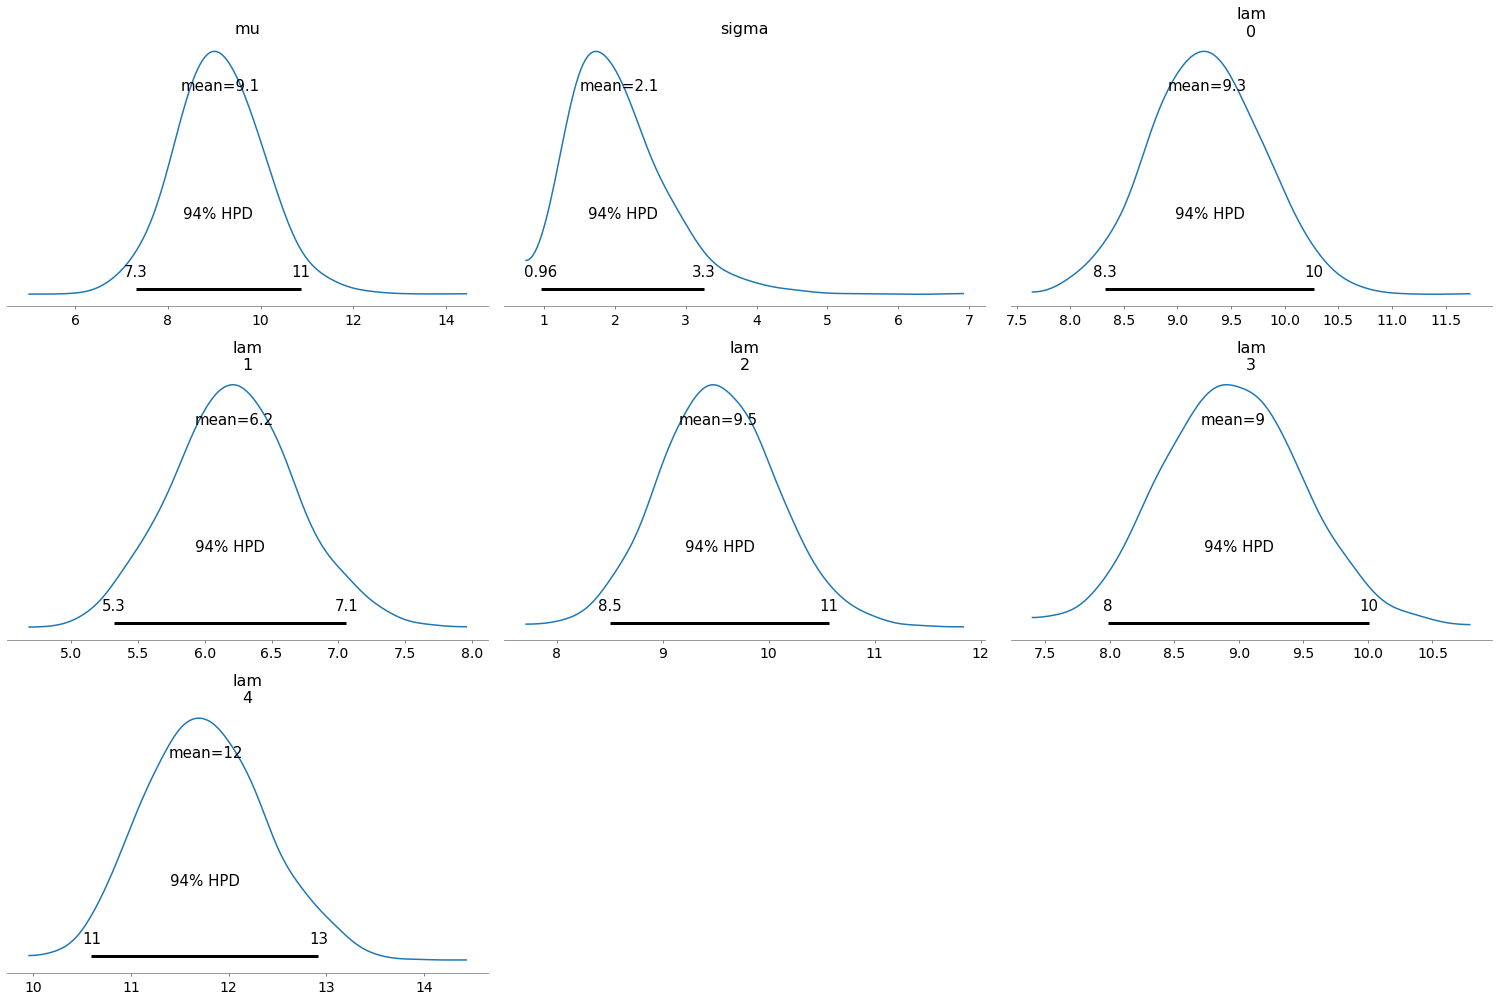

In [18]:
pm.plot_posterior(trace);

In [19]:
pm.gelman_rubin(trace)

/home/devendra/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:    (lam_dim_0: 5)
Coordinates:
  * lam_dim_0  (lam_dim_0) int64 0 1 2 3 4
Data variables:
    mu         float64 1.0
    sigma      float64 1.001
    lam        (lam_dim_0) float64 1.002 1.0 1.0 1.002 1.001

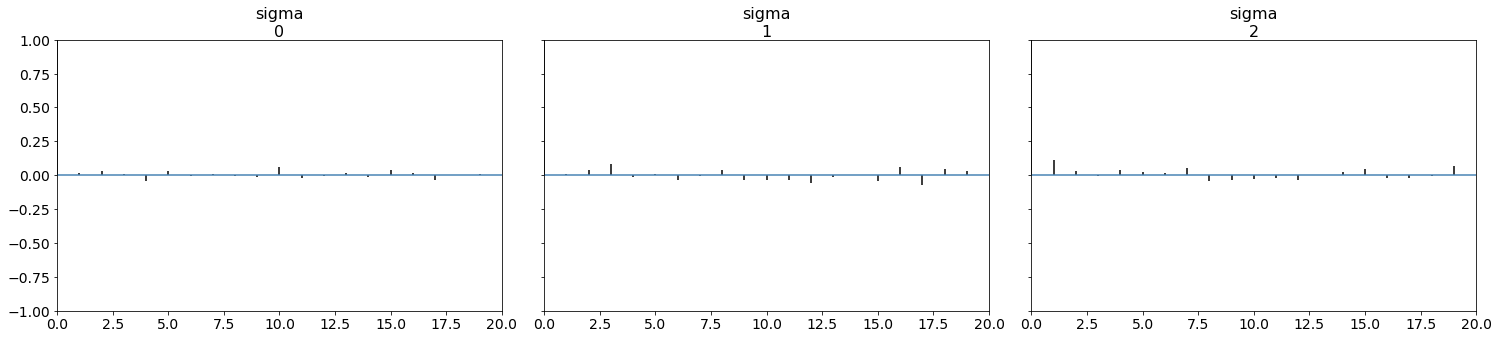

In [20]:
pm.autocorrplot(trace, var_names=['sigma'], max_lag=20);

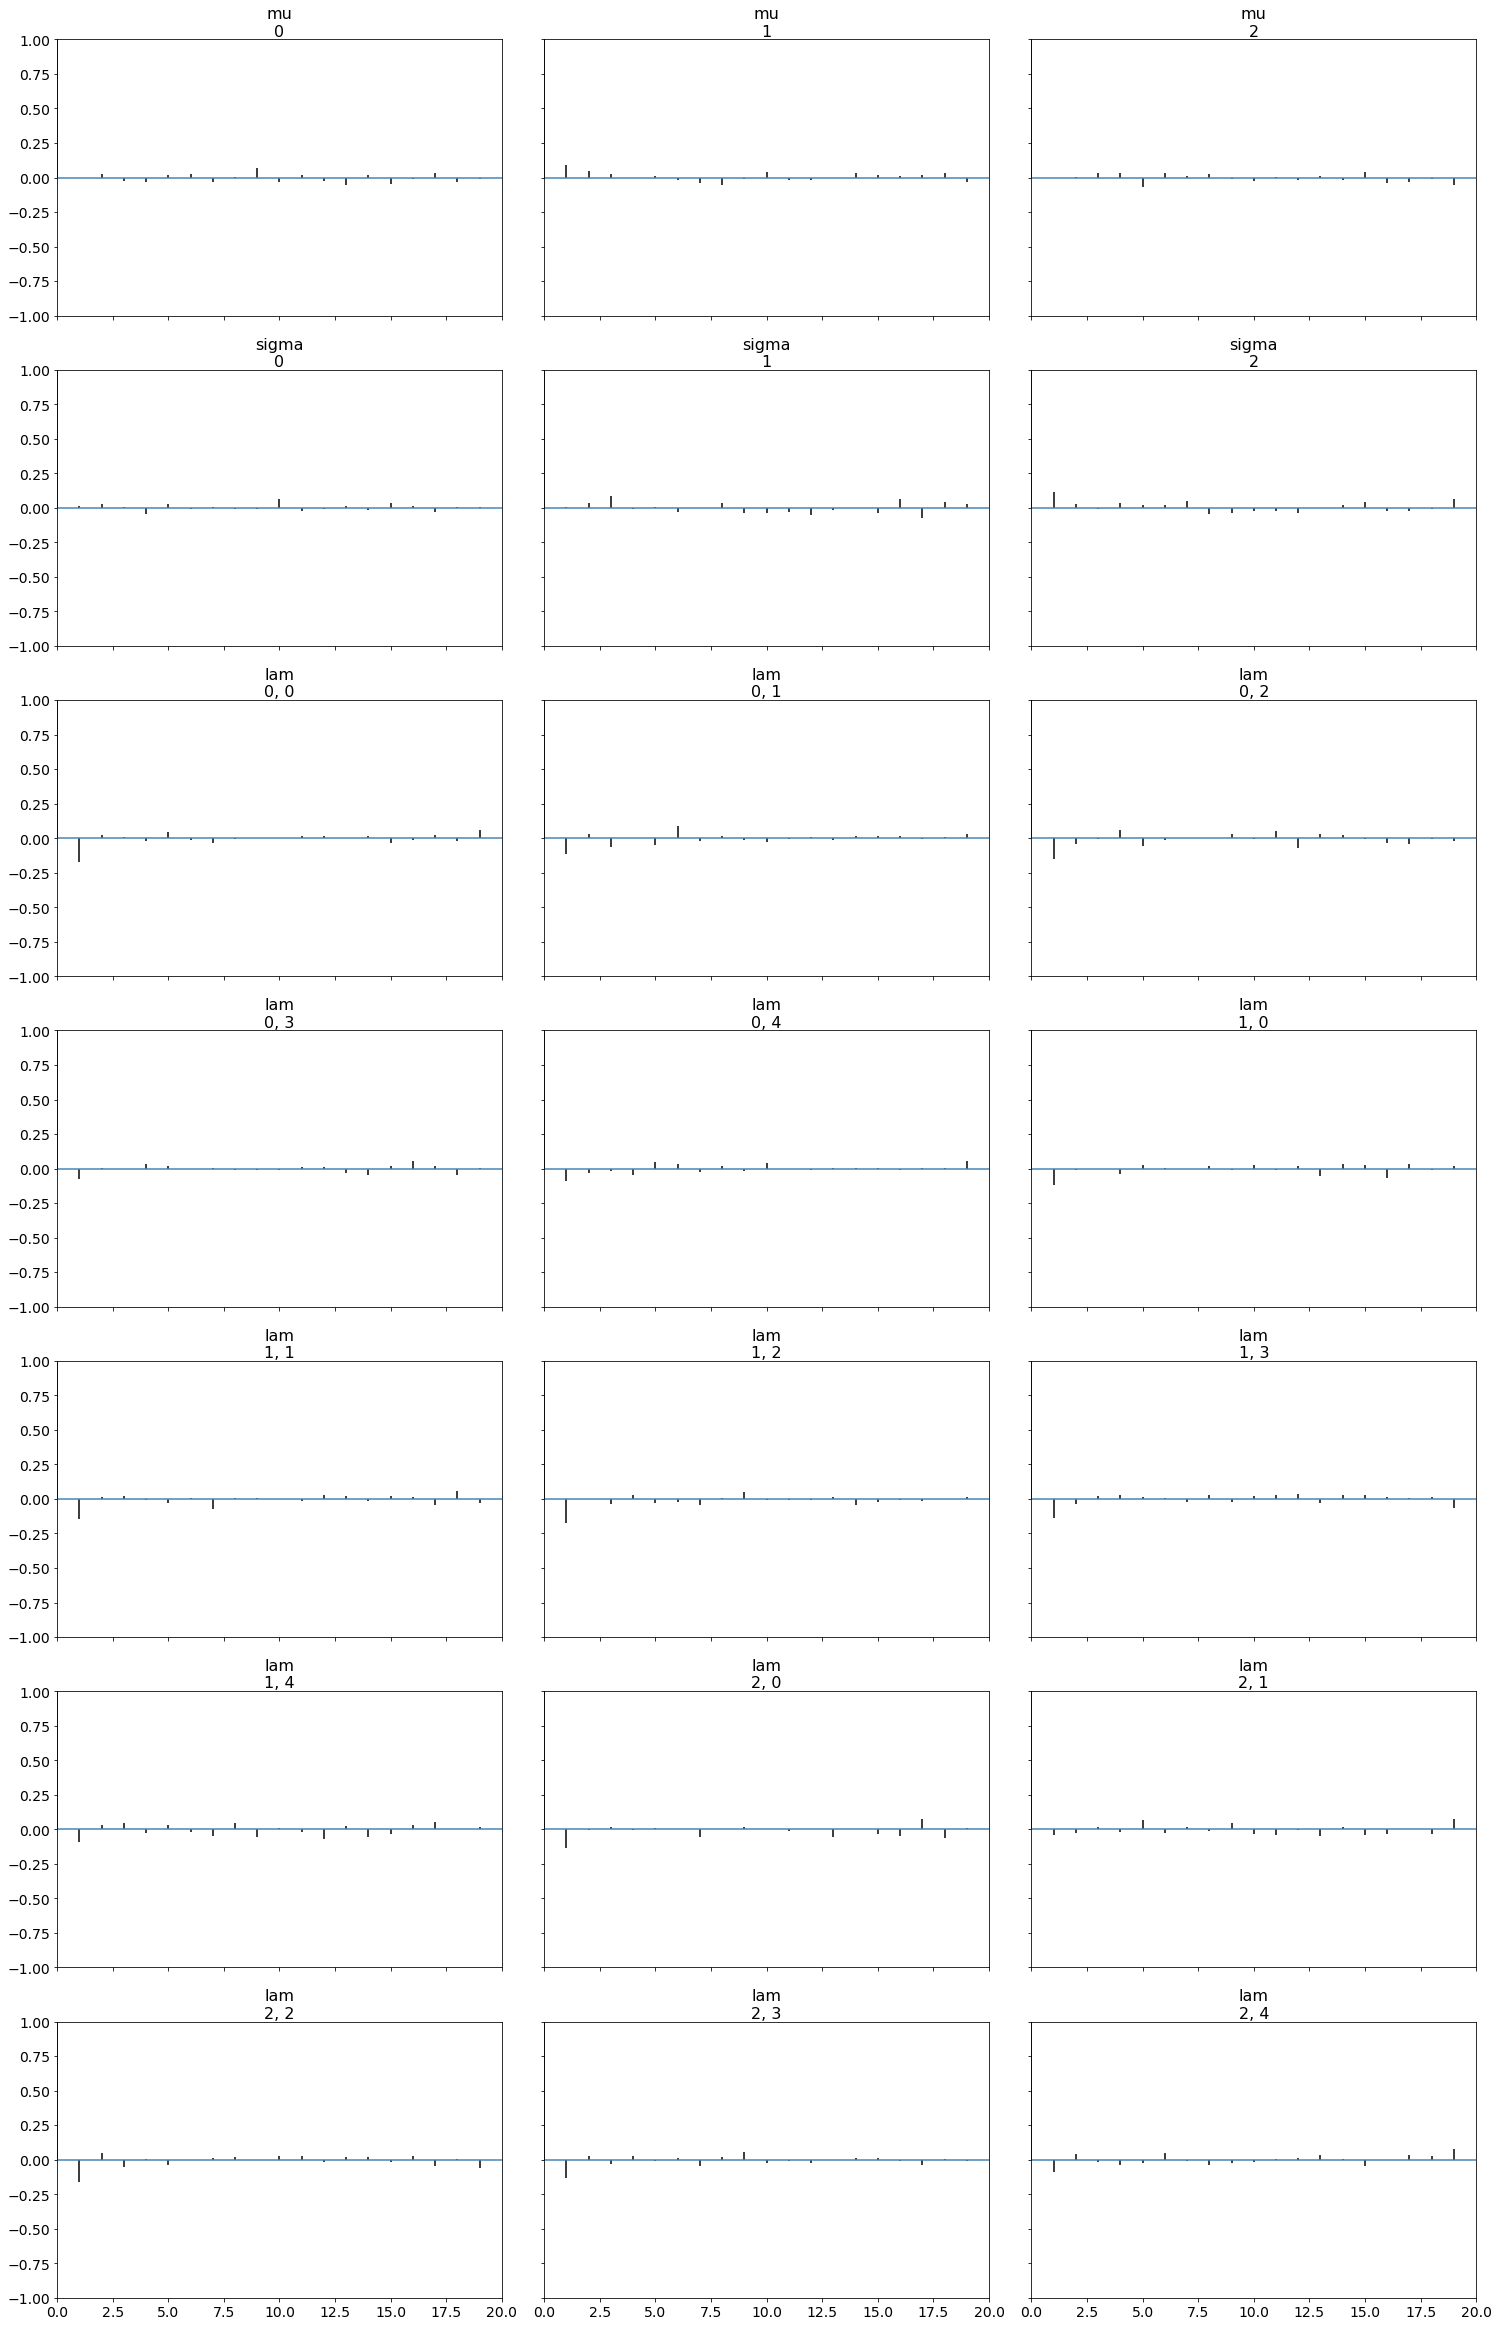

In [21]:
pm.autocorrplot(trace, max_lag=20);

In [23]:
pm.effective_n(trace)

/home/devendra/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:50: UserWarning: effective_n has been deprecated. In the future, use ess instead.
  warnings.warn("effective_n has been deprecated. In the future, use ess instead.")


<xarray.Dataset>
Dimensions:    (lam_dim_0: 5)
Coordinates:
  * lam_dim_0  (lam_dim_0) int64 0 1 2 3 4
Data variables:
    mu         float64 2.768e+03
    sigma      float64 2.703e+03
    lam        (lam_dim_0) float64 4.024e+03 3.684e+03 ... 3.884e+03 3.524e+03

In [26]:
#pm.waic(trace, model)

In [30]:
# Compute the mean of the simulation.
lambda_mean = np.apply_along_axis(np.mean, 0, trace['lam'])

# Compute for each sample the posterior mean
cookies['yhat'] = cookies.location.apply(lambda x: lambda_mean[x-1])

# Compute the residuals.
cookies['resid'] = cookies.apply(lambda x: x.chips - x.yhat, axis=1)

cookies.head()

,chips,location,yhat,resid
0,12,1,9.275363,2.724637
1,12,1,9.275363,2.724637
2,6,1,9.275363,-3.275363
3,13,1,9.275363,3.724637
4,12,1,9.275363,2.724637


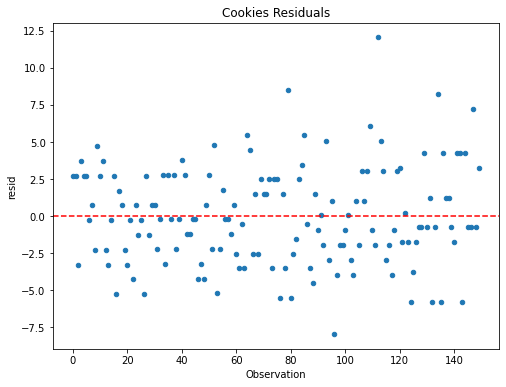

In [31]:
# Cookies Residuals
fig, ax = plt.subplots(figsize=(8, 6))
cookies.reset_index().plot.scatter(x='index', y='resid', ax=ax)
ax.axhline(y=0.0, color='r', linestyle='--')
ax.set(title='Cookies Residuals', xlabel='Observation');

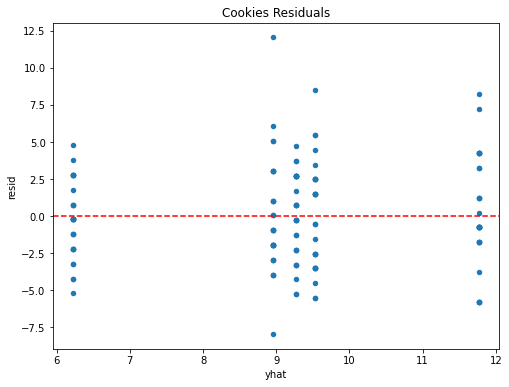

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
cookies.plot.scatter(x='yhat', y='resid', ax=ax)
ax.axhline(y=0.0, color='red', linestyle='--')
ax.set(title='Cookies Residuals');

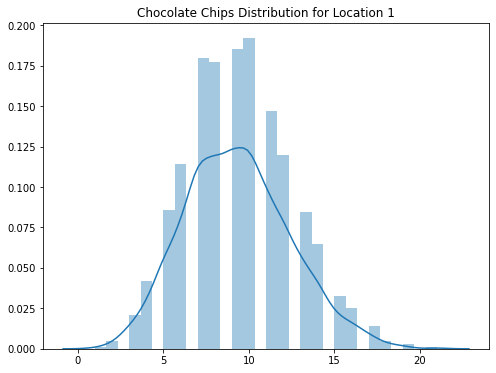

In [33]:
# We generate n_sim samples of a Poisson distribution for 
# each value for lam_0 (location 1) simulation..
y_pred_location_1 = np.random.poisson(lam=trace['lam'][:,0] , size=n_sim)

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_pred_location_1, bins=30, ax=ax)
ax.set(title='Chocolate Chips Distribution for Location 1');

In [34]:
# Probability the next cookie in location has less than 7 chips.
(y_pred_location_1 < 7).astype(int).mean()

0.17933333333333334

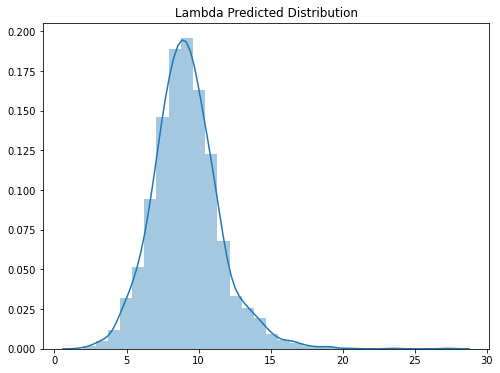

In [35]:
# Posterior distribution of for a an b 
# from the simulated values of mu and sigma2.
post_a = trace['mu']**2/trace['sigma']**2
post_b = trace['mu']/trace['sigma']**2

# We now generate samples of a gamma distribution 
# with these generated parameters of a and b.
lambda_pred_dist = np.random.gamma(post_a, 1/post_b, n_sim) 

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(lambda_pred_dist, bins=30, ax=ax)
ax.set(title='Lambda Predicted Distribution');

In [36]:
# Posterior probability a new location has lambda > 15.
(lambda_pred_dist > 15).astype(int).mean()

0.016666666666666666

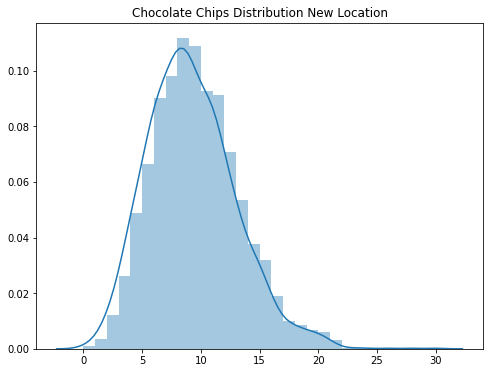

In [37]:
# Posterior distribution of the chips.
# Here we use the values of lambda obtained above.
cookies_pred_dist = np.random.poisson(lam=lambda_pred_dist, size=n_sim)

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(cookies_pred_dist, bins=30, ax=ax)
ax.set(title='Chocolate Chips Distribution New Location');

In [38]:
# Posterior probability that a cookie produced 
# in a new location has more than 15 chocolate chips.
(cookies_pred_dist>15).astype(int).mean()

0.05566666666666667